# Multiomics analysis with `muon` - Vertical integration

In this notebook we will perform exploratory analysis and joint dimensionality reduction on unmatched scRNA-seq and scATAC-seq data of differentiating glutamatergic neurons from [Trevino et al.2020](https://www.biorxiv.org/content/10.1101/2020.12.29.424636v2.full). The original datasets can be downloaded following the instructions in https://github.com/GreenleafLab/brainchromatin. The data was cleaned and converted to `anndata` objects in the script `prep_data.Rmd`.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [2]:
import muon as mu

In [3]:
## Plotting utils
import matplotlib.pyplot as plt
import matplotlib

## Load single-view data

The data for each omic view is stored in [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) format. An `AnnData` object allows us to store a matrix and add annotations to its different dimensions, defined as “observations” (i.e. cells), and measured “variables” (i.e. genes for the RNA view and peaks for the ATAC modalities).

In [ ]:
rna_adata = sc.read_h5ad('/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/scRNA_clean_SCE.h5ad')
atac_adata = sc.read_h5ad('/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/scATAC_clean_SCE.h5ad')

In [ ]:
# rna_adata = sc.read_h5ad('./processed_data/scRNA.h5ad')
# atac_adata = sc.read_h5ad('./processed_data/scATAC_clean_SCE.h5ad')

We can access the annotations on cells using `adata.obs`

In [ ]:
rna_adata.obs

In [ ]:
atac_adata.obs

We can access the annotation on features with `adata.var`. In the ATAC object `atac_adata.var` also stores the genomic coordinates of the peaks. 

In [ ]:
rna_adata.var

In [ ]:
atac_adata.var

## Build `MuData` object

`muon` is a framework for multimodal data analysis with a strong focus on multi-omics.

`muon.MuData` is a multi-modal data container, that comprises a dictionary with `AnnData` objects, one per modality, in its `.mod` attribute. Just as `AnnData` objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings, etc.


In [10]:
mdata = mu.MuData({'rna': rna_adata, 'atac': atac_adata})

In [15]:
mdata

MuData object with n_obs × n_vars = 52670 × 691285
  2 modalities
    rna:	33662 x 33355
      obs:	'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode'
      var:	'gene_name'
      layers:	'counts'
    atac:	19008 x 657930
      obs:	'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'Iterative.LSI.Clusters', 'Tss.Enrichment', 'Cell.Barcode', 'TSS.Enrichment.Unsmoothed'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'name', 'classification'

You can see the object now concatenates `.obs` from both assays in a single object, and the info about the original assay for each column is saved

In [17]:
mdata.obs

,rna:Cell.ID,rna:Sample.ID,rna:Age,rna:Tissue.ID,rna:Sample.Type,rna:Assay,rna:Batch,rna:seurat_clusters,rna:RNA.Counts,rna:RNA.Features,...,atac:Cell.ID,atac:Sample.ID,atac:Age,atac:Tissue.ID,atac:Sample.Type,atac:Batch,atac:Iterative.LSI.Clusters,atac:Tss.Enrichment,atac:Cell.Barcode,atac:TSS.Enrichment.Unsmoothed
hft_w20_p3_r1_AAACCCACATAGTCAC,hft_w20_p3_r1_AAACCCACATAGTCAC,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c0,4025.0,1969.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w20_p3_r1_AAACCCAGTACAGGTG,hft_w20_p3_r1_AAACCCAGTACAGGTG,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c4,7131.0,2930.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w20_p3_r1_AAACCCAGTACGGTTT,hft_w20_p3_r1_AAACCCAGTACGGTTT,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c4,6532.0,2712.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w20_p3_r1_AAACCCAGTATGTCCA,hft_w20_p3_r1_AAACCCAGTATGTCCA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c9,953.0,523.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w20_p3_r1_AAACCCAGTTGCTCAA,hft_w20_p3_r1_AAACCCAGTTGCTCAA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c0,5857.0,2500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r3_cell_2853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,hft_w16_p7_r3_cell_2853,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c6,21.215686,TTTGGCCTCGACTTAG-1,40.000000
hft_w16_p7_r3_cell_2857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,hft_w16_p7_r3_cell_2857,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c8,14.535234,TTTGGTTAGGAGTACC-1,27.303754
hft_w16_p7_r3_cell_2859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,hft_w16_p7_r3_cell_2859,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c7,25.971143,TTTGGTTGTCGAGGAT-1,45.283019
hft_w16_p7_r3_cell_2860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,hft_w16_p7_r3_cell_2860,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c8,20.657277,TTTGGTTGTGTCGTCG-1,36.056338


Observations and variables of the `MuData` object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique.

Notably, individual modalities inside the MuData container are stored as references to the original objects and are full-fledged AnnData objects, which can be operated independently with any tool that works on AnnData objects. So if we change the single-omic `AnnData` objects, the changes will be reflected in the container.

For example, if we add a column to the `.obs` of the RNA modality object, we can see the new column is also accessible from the container.


In [18]:
rna_adata.obs["new_col"] = 0
mdata["rna"]

AnnData object with n_obs × n_vars = 33662 × 33355
    obs: 'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'new_col'
    var: 'gene_name'
    layers: 'counts'

However, the column is not found in the common `.obs`

In [19]:
"rna:new_col" in mdata.obs.columns

False

To update the common obs, we can use the `.update_obs()` method, that syncs up the data.

In [20]:
mdata.update_obs()
mdata.obs["rna:new_col"]

hft_w20_p3_r1_AAACCCACATAGTCAC    0.0
hft_w20_p3_r1_AAACCCAGTACAGGTG    0.0
hft_w20_p3_r1_AAACCCAGTACGGTTT    0.0
hft_w20_p3_r1_AAACCCAGTATGTCCA    0.0
hft_w20_p3_r1_AAACCCAGTTGCTCAA    0.0
                                 ... 
hft_w16_p7_r3_cell_2853           NaN
hft_w16_p7_r3_cell_2857           NaN
hft_w16_p7_r3_cell_2859           NaN
hft_w16_p7_r3_cell_2860           NaN
hft_w16_p7_r3_cell_2865           NaN
Name: rna:new_col, Length: 52670, dtype: float64

To update everything we can use `mdata.update()`

## Preprocessing RNA modality

For preprocessing the scRNA data we can use the standard functions implemented in `scanpy`. In this case, the count data stored in `adata.layers['counts']`, and cells have already been filtered by percentage of mitochrondrial counts and total counts.

In [42]:
rna_adata.X = rna_adata.layers["counts"].copy()
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)

We identify highly variable genes for dimensionality reduction

In [49]:
sc.pp.highly_variable_genes(rna_adata,min_mean=0.0125, max_mean=3, min_disp=0.5)

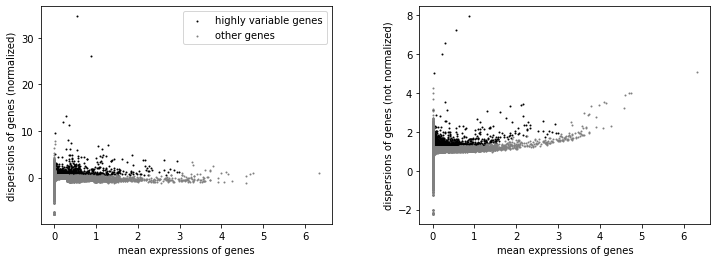

In [50]:
sc.pl.highly_variable_genes(rna_adata)

Let's check how many genes are identified as highly variable

In [51]:
np.sum(rna_adata.var.highly_variable)

2053

Next we run dimensionality reduction with PCA and use PCs to construct a K-nearest neighbor graph for visualization of our cells in UMAP

In [52]:
sc.pp.pca(rna_adata)
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(rna_adata)

In [54]:
rna_adata

AnnData object with n_obs × n_vars = 33662 × 33355
    obs: 'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'new_col'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'seurat_clusters_colors', 'Batch_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

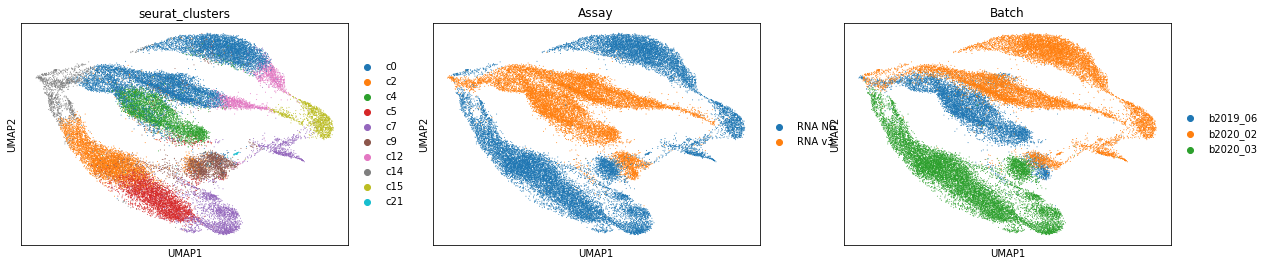

In [70]:
sc.pl.umap(rna_adata, color=["seurat_clusters","Assay", "Batch"])

We can see differences in expression of known marker genes for neuronal intermediate progenitor cells (nIPC) and glutamatergic excitatory neurons (GluN)

In [39]:
'NEUROG1' in rna_adata.var_names

False

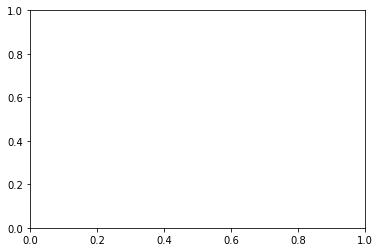

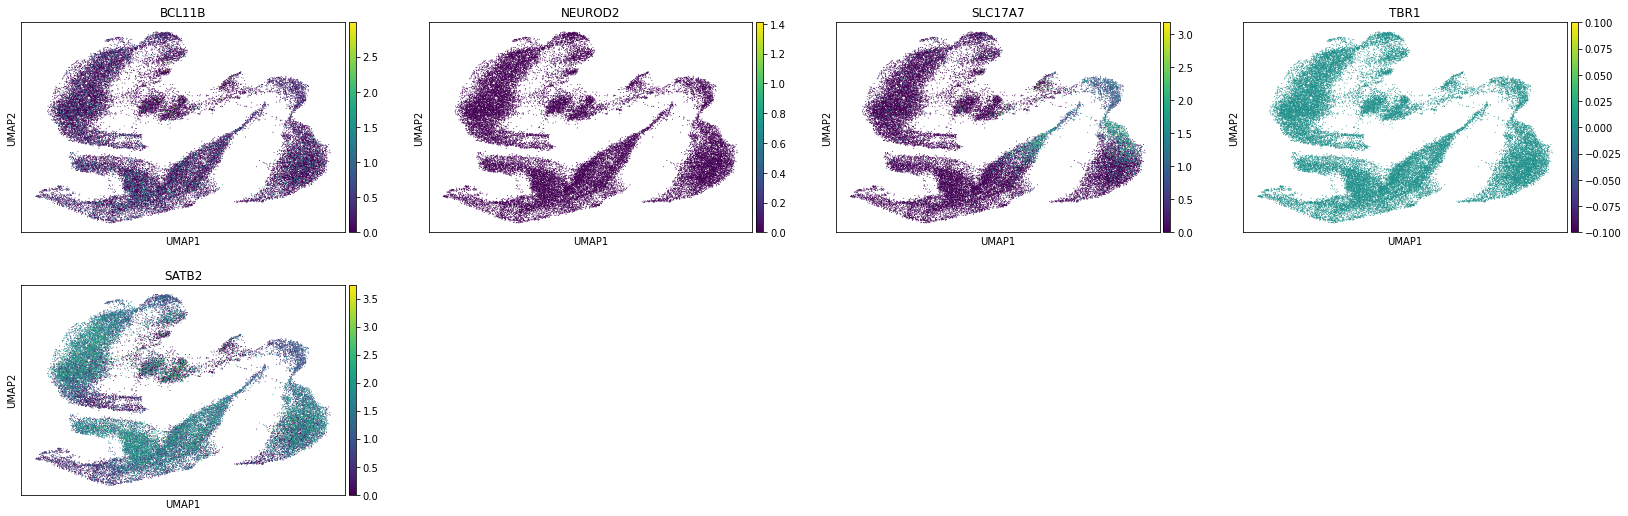

In [34]:
marker_genes = {
    "nIPC":['EOMES', 'PPP1R17', 'PENK', 'NEUROG1', 'NEUROG2'],
    "GluN":['NEUROD2', 'TBR1', 'BCL11B', 'SATB2', 'SLC17A7']
               }

rna_adata.var_names = rna_adata.var["gene_name"].values.copy()
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["nIPC"])])
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["GluN"])])

We can use ordinary diffusion pseudotime to order excitatory neurons along a differentiation trajectory stemming from the nIPCs. 

In [ ]:
sc.tl.diffmap(rna_adata)
sc.pl.diffmap(rna_adata, color=marker_genes['nIPC'])

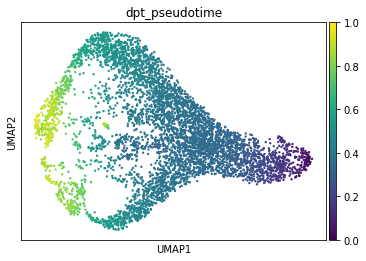

In [33]:
## Define the putative root cell (start of differentiation trajectory)
## we take the minimum for DC1 as the root nIPC
rna_adata.uns['iroot'] = rna_adata.obsm["X_diffmap"][:,1].argmin() 
sc.tl.dpt(rna_adata)
sc.pl.umap(rna_adata, color=["dpt_pseudotime"])

We can already observe different patterns of expression along pseudotime for the GluN marker genes

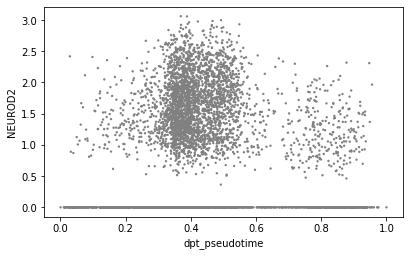

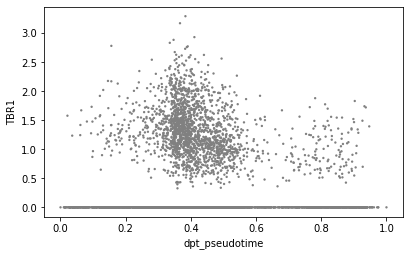

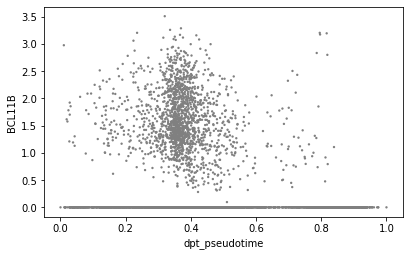

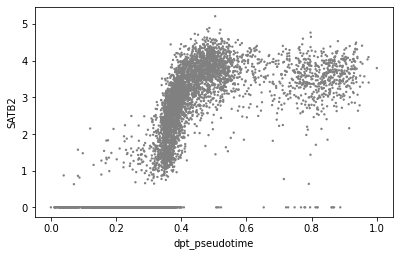

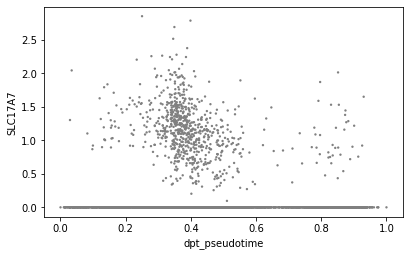

In [46]:
for g in marker_genes["GluN"]:
    sc.pl.scatter(rna_adata, 'dpt_pseudotime', g)

---

## Preprocessing ATAC modality

We are going to use the functions for preprocessing of scATAC data in python implemented in `muon`

In [56]:
from muon import atac as ac

Again, here QC metrics such as the signal at Transcriptional Start Sites and cell and gene filtering was already performed. Let's recalculate QC metric just to check the distribution of certain metrics

In [57]:
sc.pp.calculate_qc_metrics(atac_adata, percent_top=None, log1p=False, inplace=True)

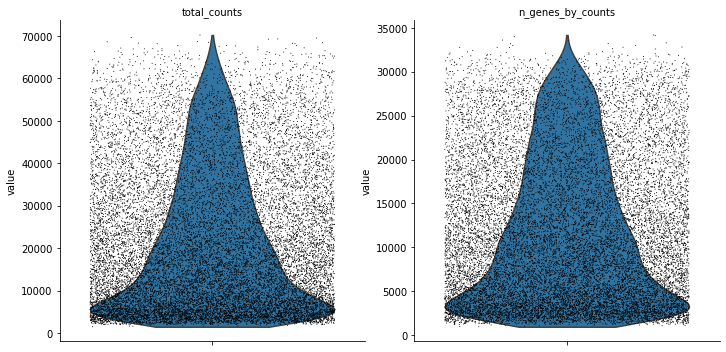

In [58]:
sc.pl.violin(atac_adata, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

We now binarize the count matrix: since scATAC data is extremely sparse and most non-zero values in it are 1 and 2.

In [59]:
ac.pp.binarize(atac_adata)

Then we normalize the data using TF-IDF (Term Frequency - Inverse Document Frequency). This is a normalization technique adapted from text processing, in this case we consider each peak as a "term" and each cell as a "document". This is typically followed by singular value decomposition (SVD) — the same technique that convential principal component analysis (PCA) uses — to generate latent components, and these two steps together are referred to as latent semantic indexing (LSI).

In [60]:
ac.pp.tfidf(atac_adata, scale_factor=1e4)

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/muon/_atac/preproc.py:64: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.asarray(adata.shape[0] / adata.X.sum(axis=0)).reshape(-1)


In [61]:
## For the PCA step, we can use the standard scanpy function or ac.pp.lsi
sc.pp.pca(atac_adata)

A word of caution on LSI: typically we see that the first latent factor or the first few latent factors found with this procedure are very strongly correlated with the total counts in the cells. Some workflows suggest excluding these latent factors that simply capture the coverage. In practice, it's not straight-forward to decide which latent factors whould be kept and which should be excluded, so for now we keep them all.

In [62]:
atac_adata.obsm["X_lsi"] = atac_adata.obsm["X_pca"].copy()
atac_adata.obs["LSI_f1"] = atac_adata.obsm["X_lsi"][:,0]
atac_adata.obs["LSI_f2"] = atac_adata.obsm["X_lsi"][:,1]

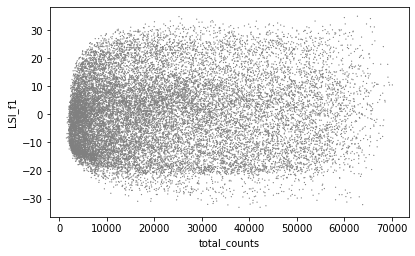

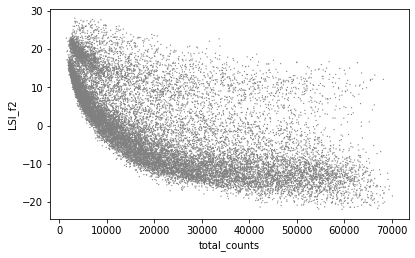

In [63]:
sc.pl.scatter(atac_adata, "total_counts", "LSI_f1")
sc.pl.scatter(atac_adata, "total_counts", "LSI_f2")

We can now compute a KNN graph for clustering and UMAP

In [64]:
sc.pp.neighbors(atac_adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(atac_adata)

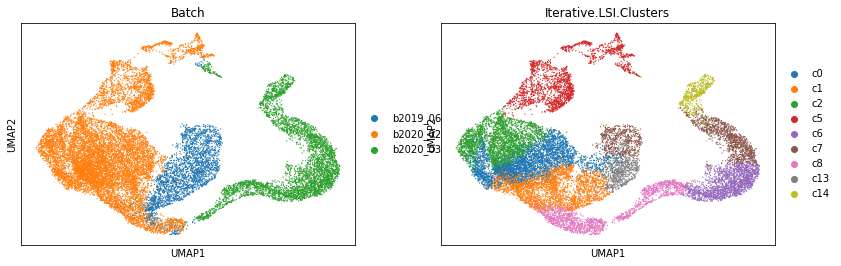

In [69]:
sc.pl.umap(atac_adata, color=['Batch', "Iterative.LSI.Clusters"])

As for the RNA, we can use ordinary diffusion pseudotime to order excitatory neurons along a differentiation trajectory stemming from the nIPCs. 

In [ ]:
sc.tl.diffmap(atac_adata)
sc.pl.diffmap(atac_adata, color="seurat_clusters")

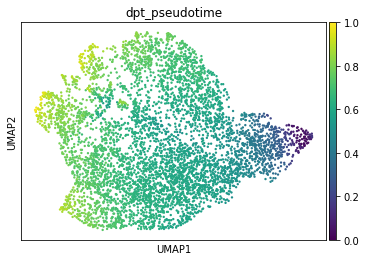

In [84]:
## Let's use the same root cell used in RNA
atac_adata.uns['iroot'] = rna_adata.uns['iroot'].copy()
sc.tl.dpt(atac_adata)
sc.pl.umap(atac_adata, color=["dpt_pseudotime"])

---

## Multi-modal analysis

Now it's time to start the joint analysis of scRNA and scATAC, where we aim to identify non-coding chromatin regions associated with expression of variable genes during excitatory neuron development.

Firstly, let's save the progress we've done on the single-modalities in the `.obs` of the multi-omic object container

In [86]:
mdata.update_obs()

Now we can jointly visualize ATAC and RNA features. For example, let's check the correspondance between the pseudotime trajectory inferred on scRNA and on scATAC.

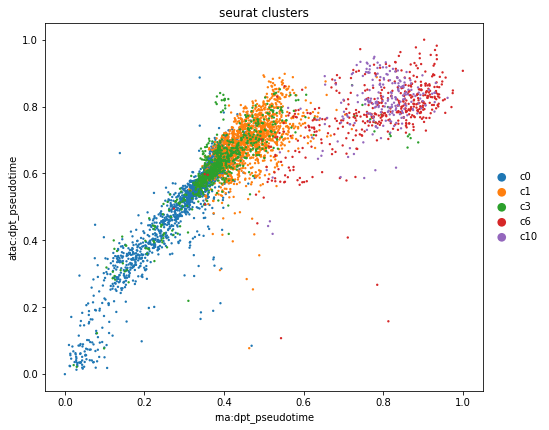

In [95]:
plt.rcParams["figure.figsize"] = [7,7]
sc.pl.scatter(mdata, "rna:dpt_pseudotime", "atac:dpt_pseudotime", color='seurat_clusters')

Looking at this plot, we can speculate that cells in the initial stages of differentiation from nIPCs seem to progress "faster" in ATAC pseudotime than in RNA pseudotime, while the opposite is true towards the end of the differentiation trajectory. This supports the notion of chromatin accessibility changes preceding RNA expression changes during development.

But let's do some real analysis...

---

## Multi-modal embedding
Let's try two different ways to project cells in a latent space that incorporates information from both modalities (as opposed to e.g. running PCA and clustering on the RNA modality and seeing how it segregates ATAC data). 


### Weighted Nearest Neighbors

We start by using the Weighted Nearest Neighbor (WNN) method presented in [Cao et al. 2021](https://www.cell.com/cell/fulltext/S0092-8674(21)00583-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421005833%3Fshowall%3Dtrue). We use the python reimplementation found in `muon`. We first need to calculate the KNN graph for each modality.

In [185]:
mu.pp.neighbors(mdata)

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynnd

The WNN graph is stored as a `.obsp` slot common to both modalities

In [189]:
mdata.obsp

PairwiseArrays with keys: distances, connectivities

We can then use this common graph for UMAP embedding

In [190]:
mu.tl.umap(mdata)

In [1]:
sc.pl.umap(mdata, color="seurat_clusters", title="Multi-modal embedding (WNN)")

NameError: name 'sc' is not defined

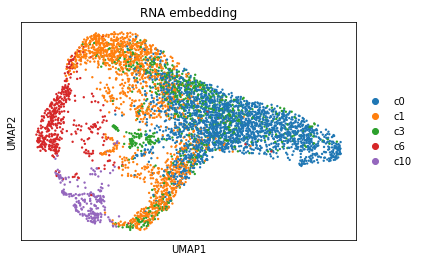

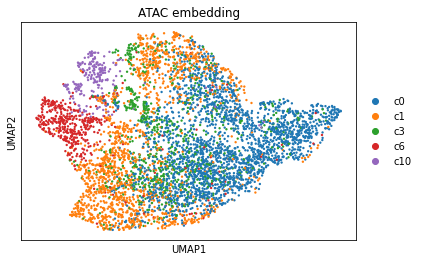

In [194]:
sc.pl.umap(mdata["rna"], color="seurat_clusters", title="RNA embedding")
sc.pl.umap(mdata["atac"], color="seurat_clusters", title="ATAC embedding")

Let's save our progress in a `.h5mu` object

In [238]:
mdata.write("../processed_data/Multiome_ext_trajectory.h5mu")

### Multi-Omics Factor analysis

Another method for multi-modal latent embedding is [Multi Omics Factor Analysis](https://github.com/bioFAM/MOFA2). This is also implemented in `muon`. For MOFA it's better to select highly variable peaks

In [232]:
sc.pp.highly_variable_genes(atac_adata, flavor="seurat", n_top_genes=10000)
mdata.update() ## to save in mdata.var

In [244]:
mu.tl.mofa(mdata, use_var="highly_variable")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=5374 samples and D=4499 features...
Loaded view='atac' group='group1' with N=5374 samples and D=10000 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: 

---

## Infer differentiation trajectories

Let's try to infer trajectory with diffusion pseudotime with KNN graphs from different modalities or with WNN graph

In [202]:
sc.tl.diffmap(mdata)

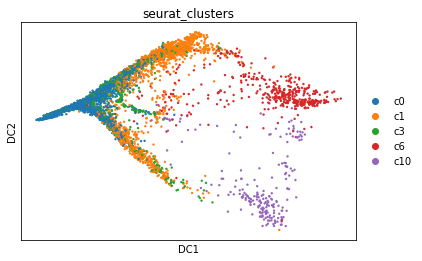

In [204]:
sc.pl.diffmap(mdata, color="seurat_clusters")

In [223]:
mdata.update_obs()

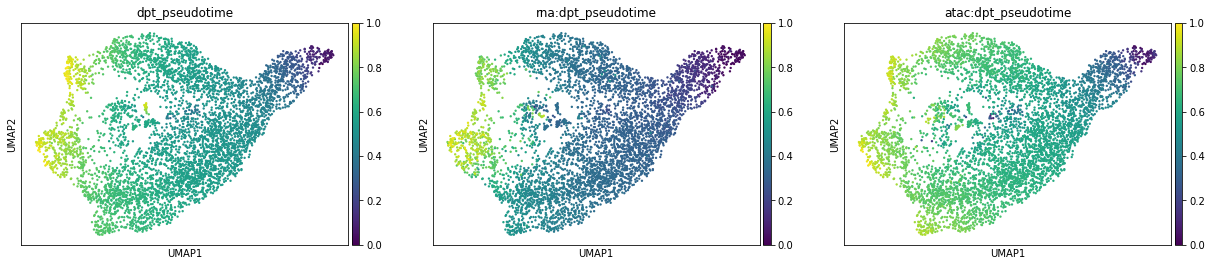

In [225]:
sc.pl.umap(mdata, color=["dpt_pseudotime","rna:dpt_pseudotime", "atac:dpt_pseudotime"])

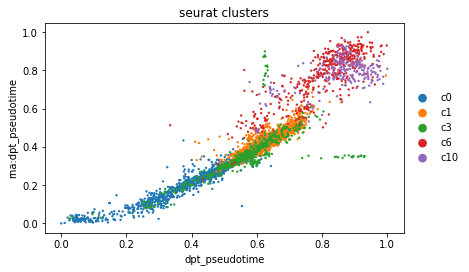

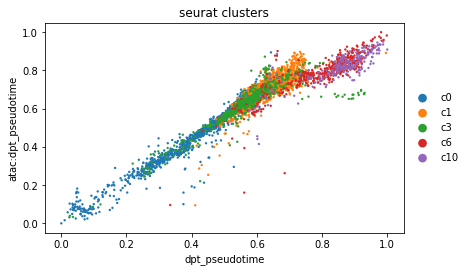

In [228]:
sc.pl.scatter(mdata, "dpt_pseudotime", "rna:dpt_pseudotime" , color="seurat_clusters")
sc.pl.scatter(mdata, "dpt_pseudotime", "atac:dpt_pseudotime", color="seurat_clusters")

---

## Associating gene expression to accessibility

We first want to find genes that have variable expression in pseudotime. We will restrict the search to peaks associated to these variable genes.

We take a naive approach, correlating log-counts in expression to the value of pseudotime in the joint embedding. For better approaches to find variable genes in pseudotime, see (A) cellrank, (B) tradeSeq and (C) ...

**consider aggregating cells by pseudotime or clusters**

In [314]:
from scipy.stats import pearsonr
X_logcounts = mdata['rna'].X.T
keep_genes = np.where(X_logcounts.sum(1) > 50)[0]
X_logcounts = X_logcounts[keep_genes,:] ## filter genes with > 50 counts across all cells
mdata['rna'].var["dpt_corr_r2"] = np.nan
mdata['rna'].var["dpt_corr_r2"] = np.nan
for i in range(X_logcounts.shape[0]):
    r2,pval = pearsonr(mdata.obs["dpt_pseudotime"],X_logcounts[i,:].toarray().flatten())
    mdata['rna'].var.loc[mdata.var_names[keep_genes[i]],"dpt_corr_r2"] = r2
    mdata['rna'].var.loc[mdata.var_names[keep_genes[i]],"dpt_corr_pval"] = pval

In [317]:
## Adjust for multiple testing
from statsmodels.stats import multitest
_,adj_pvals,_,_ = multitest.multipletests(mdata['rna'].var["dpt_corr_pval"].dropna(), method="fdr_bh")

In [320]:
mdata['rna'].var["dpt_corr_adj_pval"] = np.nan
mdata['rna'].var.loc[~mdata['rna'].var["dpt_corr_pval"].isna(), "dpt_corr_adj_pval"] = adj_pvals

Let's see how the correlations look like

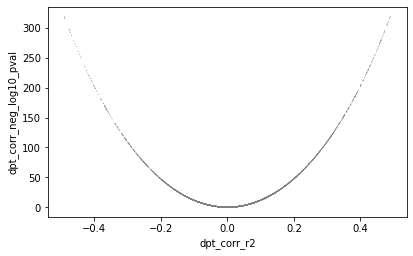

In [321]:
mdata['rna'].var["dpt_corr_neg_log10_pval"] = -np.log10(mdata['rna'].var["dpt_corr_adj_pval"])
sc.pl.scatter(mdata['rna'], "dpt_corr_r2", "dpt_corr_neg_log10_pval")

We define as associated to pseudotime genes with absolute correlation > 0.2

In [332]:
mdata['rna'].var["dpt_associated_gene"] = abs(mdata['rna'].var["dpt_corr_r2"]) > 0.2

Let's plot the expression of these genes

In [342]:
mdata["rna"][:,mdata['rna'].var["dpt_associated_gene"]].X.toarray()

array([[0.       , 1.6113607, 0.       , ..., 0.       , 0.       ,
        1.6113607],
       [0.       , 0.       , 0.       , ..., 3.5676517, 2.523948 ,
        3.6455212],
       [0.       , 1.352047 , 0.       , ..., 3.3895733, 2.9009807,
        3.2879527],
       ...,
       [0.       , 0.       , 1.0355058, ..., 2.1121655, 2.1121655,
        1.5332178],
       [1.2353609, 0.       , 0.       , ..., 4.5137773, 3.9556954,
        3.9078622],
       [0.       , 0.       , 0.       , ..., 0.       , 1.7229856,
        0.       ]], dtype=float32)

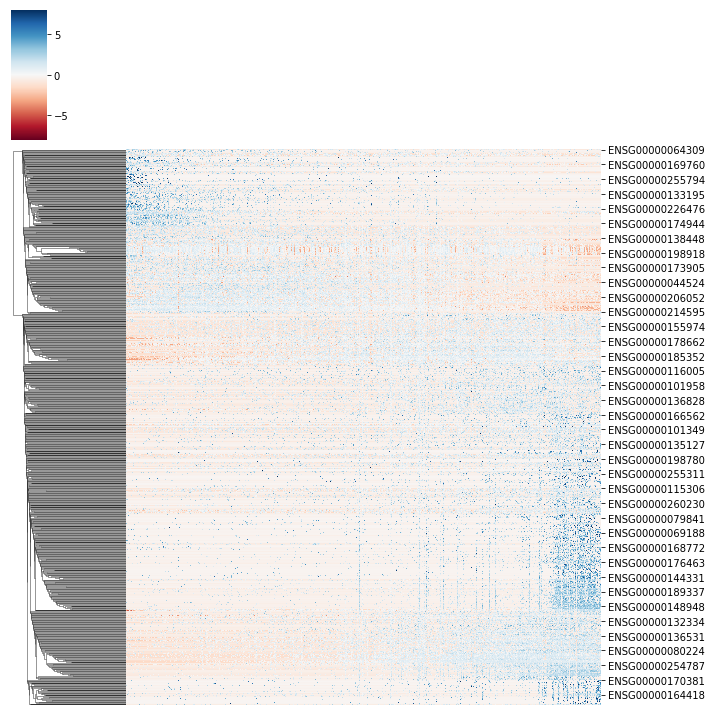

In [364]:
## Extract expression matrix with genes ordered by pseudotime
dpt_order_gex_matrix = mdata["rna"][mdata.obs["dpt_pseudotime"].argsort(),mdata['rna'].var["dpt_associated_gene"]].X.toarray()
dpt_order_gex_matrix = sc.pp.scale(dpt_order_gex_matrix)
dpt_order_gex_matrix = pd.DataFrame(dpt_order_gex_matrix.T)
dpt_order_gex_matrix.index = mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]]

import seaborn as sns
plt.rcParams["figure.figsize"] = [10,10]
sns.clustermap(dpt_order_gex_matrix, xticklabels=False, col_cluster=False, cmap="RdBu",
              vmin=-8, vmax=8)

Next, we identify peaks that are close to these genes, within 50 kb. 

In [366]:
genes_oi = mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]]

In [397]:
peaks = mdata['atac'].var["seqnames"].astype("str") + ":" +\
mdata['atac'].var["start"].astype("str") + '-' +\
mdata['atac'].var["end"].astype("str")

In [402]:
peaks = mdata['atac'].var[["seqnames", "start", "end"]]

Let's set up `rpy2` usage to use R functions within this python notebook: I use the annotations in `ensembldb` to extract genomic positions for these genes and I use `GenomicRanges` to do feature overlaps.

In [412]:
import anndata2ri

In [373]:
import rpy2.rinterface_lib.callbacks
import logging

In [374]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [406]:
%%R
library(tidyr)
library(Matrix)
library(ensembldb)
library(EnsDb.Hsapiens.v86) ## Remember to pick your genome!

R[write to console]: 
Attaching package: 'Matrix'


R[write to console]: The following objects are masked from 'package:tidyr':

    expand, pack, unpack


R[write to console]: The following object is masked from 'package:S4Vectors':

    expand




In [385]:
%%R
## String - GRanges conversion
## Borrowed from Signac functions 
## https://satijalab.org/signac/reference/GRangesToString.html
StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}


In [407]:
%%R  -i peaks -i genes_oi -o adj_mat
genes_gr <- genes(EnsDb.Hsapiens.v86)[genes_oi]
peaks_gr <- makeGRangesFromDataFrame(peaks)

## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=50000)

In [413]:
adj_mat = anndata2ri.r2py.rmat_to_spmat(adj_mat)

How many peaks are close to these genes?

In [425]:
np.array((adj_mat.T.sum(0) != 0)).ravel()

68834

We save the association of peaks to genes in the `.varm` slot of the `atac` modality

In [428]:
mdata["atac"].varm["peak2gene_matching"] = adj_mat

Now we can test for associations using pearson's correlation. To increase the power here, we aggregate peak and gene counts by bins of pseudotime.

In [451]:
mdata.obs["dpt_pseudotime_bin"] = pd.cut(mdata.obs["dpt_pseudotime"], bins=500).astype("category").cat.codes

In [429]:
# ...

In [438]:
# ...

<5374x351 sparse matrix of type '<class 'numpy.float32'>'
	with 29601 stored elements in Compressed Sparse Row format>